In [29]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min,c_max = df[col].min(),df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16) 
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_df = read_parquet_files()
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]


Memory usage of dataframe is 14427.07 MB
Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 84)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0.775879
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0.703613
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,2.109375
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,1.114258
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969,-3.572266


In [8]:
train_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47127338 entries, 0 to 47127337
Data columns (total 84 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   date_id      47127338 non-null  int16  
 1   time_id      47127338 non-null  int16  
 2   symbol_id    47127338 non-null  int8   
 3   weight       47127338 non-null  float16
 4   feature_00   43945286 non-null  float16
 5   feature_01   43945286 non-null  float16
 6   feature_02   43945286 non-null  float16
 7   feature_03   43945286 non-null  float16
 8   feature_04   43945286 non-null  float16
 9   feature_05   47127338 non-null  float16
 10  feature_06   47127338 non-null  float16
 11  feature_07   47127338 non-null  float16
 12  feature_08   46827091 non-null  float16
 13  feature_09   47127338 non-null  int8   
 14  feature_10   47127338 non-null  int8   
 15  feature_11   47127338 non-null  int16  
 16  feature_12   47127338 non-null  float16
 17  feature_13   47127338 non

In [9]:
test_df = read_parquet_files(train_or_test='test')
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.82it/s]

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 25.8%
(39, 85)


,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169922,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.166016,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2,0,0,2,3.066406,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,3,0,0,3,2.699219,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,4,0,0,4,1.803711,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,5,0,0,5,2.605469,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,6,0,0,6,1.047852,1.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,7,0,0,7,4.230469,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,8,0,0,8,2.599609,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.

In [10]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.38it/s]

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [11]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [12]:
cat_cols = ['symbol_id']

In [13]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        #df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique())

        for v in unique_list:
            new_col_name = col + '_' + str(v)
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [14]:
train_df = one_hot_cat_cols(train_df)
print(train_df.shape)
train_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]


(47127338, 122)


,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0.775879,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0.703613,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,2.109375,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,1.114258,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

In [15]:
train_df.tail()

,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
47127333,1698,967,3.242188,2.525391,-0.722168,2.544922,2.478516,0.417480,0.785645,1.118164,2.199219,0.415527,42,5,150,0.804199,1.157227,1.031250,-0.671387,-0.328613,-0.486084,1.730469,-0.006172,-0.001144,-0.213013,0.932617,1.367188,-0.238159,-0.692383,-0.121155,1.090820,1.444336,-0.675781,-1.013672,-0.242920,3.427734,-0.958496,3.140625,3.416016,-1.655273,-0.599609,-0.933105,2.494141,0.969238,1.101562,0.158936,-0.496094,0.036163,1.309570,0.828125,1.578125,1.041016,1.255859,2.578125,0.057465,0.953125,1.376953,-0.396240,0.520020,1.179688,1.127930,2.232422,0.614746,2.412109,-1.101562,-0.384766,-0.275879,-0.407959,2.427734,-0.108398,0.739746,0.830078,0.366211,1.333008,1.075195,1.797852,-0.183472,-0.190186,0.234253,0.347168,-0.044464,0.016937,-0.132324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
47127334,1698,967,1.079102,1.857422,-0.790527,2.746094,2.339844,0.845215,0.651367,1.180664,1.966797,0.321533,25,7,195,-0.075317,-0.152710,-0.204224,-0.421143,0.217041,-0.258789,1.875000,0.199829,-0.199219,-0.125610,-1.004883,-0.051941,0.450928,0.009247,0.164185,-0.939941,-1.143555,-0.320068,-0.379883,-0.142456,3.863281,-1.452148,3.476562,2.861328,0.763672,0.075989,-0.119690,0.625977,0.148804,0.653320,0.059326,-0.845215,0.098511,0.409668,-0.675781,-0.011337,0.930664,0.832031,0.809082,0.219238,-0.315674,0.687988,-1.189453,0.180176,-0.175537,-1.604492,-0.209229,0.249878,0.288818,-1.101562,-0.343750,-0.253906,-0.278809,2.050781,-0.059509,-0.029404,-0.101379,-0.187744,-0.180786,-0.086121,-0.153442,-0.196045,-0.175293,1.045898,0.739746,0.033722,0.050873,-0.249634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
47127335,1698,967,1.033203,2.515625,-0.672363,2.289062,2.521484,0.255127,0.919922,1.171875,2.179688,0.248413,49,7,297,1.026367,-0.096863,0.224365,-0.528320,-0.705078,-0.704590,2.312500,0.328125,-0.108215,NaN,-0.945801,-0.244141,0.205933,-0.357422,NaN,NaN,-1.110352,-0.580078,-0.400635,NaN,2.398438,-0.637207,3.259766,3.046875,0.440918,0.234863,-0.175537,1.022461,-0.500000,2.070312,0.413574,-0.449951,-0.156616,-0.253662,-0.769531,0.066101,0.047821,1.713867,0.772949,-0.549316,1.338867,0.933594,0.032990,-0.519043,-0.290283,-0.806641,0.106323,0.183472,1.830078,-1.101562,-0.342041,-0.249146,-0.343750,2.251953,0.602051,1.035156,-0.283203,0.107239,0.860352,0.024216,0.374756,-0.220947,-0.161621,0.032776,0.036896,0.168945,0.152344,-0.065369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
47127336,1698,967,1.243164,2.664062,-0.889160,2.312500,3.101562,0.324463,0.619141,1.185547,1.599609

In [18]:
sample_train_df = train_df.sample(frac=0.1)
print(sample_train_df.shape)
sample_train_df.head()

(4712734, 122)


,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
30124882,1237,260,1.160156,1.478516,0.535156,1.895508,1.135742,-0.357666,1.065430,-0.704102,1.554688,-0.310303,15,1,9,1.821289,0.272949,0.516113,-0.628418,-0.601074,-0.699219,-0.126831,-0.820801,-0.729492,-0.092957,-0.483154,-0.741699,1.721680,-0.115234,-1.580078,-1.395508,-0.787598,-0.651855,-0.700684,-0.120789,-0.027710,-0.795898,0.733887,0.753906,-0.004253,0.069031,0.163330,0.333252,-0.847656,0.462646,0.343994,-0.851074,-0.239136,0.672852,0.179443,0.389404,-0.276367,0.707520,0.222168,-0.705566,-0.034210,1.063477,-0.832031,0.531738,0.327148,0.398438,0.672363,-0.546875,0.573730,0.213257,-0.482910,-0.400146,-0.392578,0.483154,-0.710938,1.708008,0.098633,0.230713,1.556641,0.514648,0.515625,0.224731,0.182861,0.338379,0.511719,0.229858,0.317871,0.557129,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3771280,282,128,1.746094,0.269531,1.403320,-0.091125,-0.515625,-0.502930,-0.447021,0.574219,0.627441,0.872559,70,7,410,0.174683,-0.403320,-0.708496,1.911133,1.250977,1.502930,-0.158569,0.338623,-0.838867,NaN,0.200439,1.270508,-1.179688,-0.953125,NaN,NaN,-0.425293,1.438477,2.158203,NaN,-0.967773,-0.710449,-0.413086,-0.958008,-0.348145,-0.216309,0.490234,-1.023438,0.289307,0.113525,-0.440186,0.436035,0.799316,0.266113,0.394043,-0.031769,-0.004948,-0.086914,0.041321,1.668945,0.405029,-1.357422,-1.334961,-1.367188,0.359619,-0.080139,0.110901,-0.002365,-0.092590,1.320312,0.445068,1.134766,0.573242,-0.077942,-0.243408,-0.038635,-0.389160,-0.513672,0.365479,-0.353516,-0.657715,-0.390869,-0.253418,-0.309326,-0.268066,-0.347656,-0.487793,-0.304932,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34103609,1343,812,4.816406,0.556641,-0.221802,-0.655762,-0.773438,1.189453,0.046387,1.958984,0.397949,-0.780762,4,3,11,-0.005108,-0.164551,-0.098083,-0.875977,-0.579102,-0.939941,0.071899,-1.905273,0.211426,0.463135,2.412109,1.648438,0.586914,1.059570,0.643066,1.287109,0.778320,-0.631836,-0.812988,0.544922,-0.520508,0.392822,-0.694336,-0.491455,0.968750,0.704102,-0.613770,1.549805,0.287109,0.568359,0.977051,-0.157593,0.073303,0.354004,-0.178467,0.532715,0.984375,0.632324,1.234375,0.329102,0.231201,0.707520,0.210938,0.989746,0.784668,-0.083008,0.651855,1.232422,0.498535,1.515625,-0.492676,-0.385986,-0.434570,0.027512,-1.414062,-0.048126,-0.387939,-0.227417,0.026794,0.107605,0.005901,-0.189941,-0.329590,-1.382812,-1.349609,-1.294922,-1.298828,-0.182739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29740696,1227,39,0.650879,3.582031,2.712891,2.298828,2.710938,2.005859,0.919434,2.501953,2.57

In [16]:
n_splits = 5

In [ ]:
#https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def r2_xgb(y_true, y_pred, sample_weight):
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return -r2

In [60]:
def xgb_train(train_data):
    #X = train_data.drop(['weight', 'responder_6', 'row_id', 'is_scored'], axis=1)
    X = train_data.drop(['weight', 'responder_6'], axis=1)
    y = train_data['responder_6']
    weights = train_data['weight']
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        #'random_state': SEED,
        #'tree_method': 'gpu_hist',
        'device': 'cuda',
        'n_estimators': 100,
        #'booster': 'gblinear'
        #'verbosity': 0
    }

    cv_fold = KFold(n_splits=n_splits)#, shuffle=True, random_state=6)

    for fold, (train_idx, test_idx) in enumerate(cv_fold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        weights_train, weights_val = weights.iloc[train_idx], weights.iloc[test_idx]

        model = XGBRegressor(
            **base_params
        )

        #model.fit(train_dmatrix, eval_set=val_dmatrix, verbose=10)
        
        model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight_eval_set=[weights_train, weights_val], verbose=10)
        
        oof[test_idx] = model.predict(X_val)

        plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        train_rmse = eval_results['validation_0']['rmse']
        val_rmse = eval_results['validation_1']['rmse']
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.ylabel('RMSE')
        plt.title('Training vs Validation RMSE')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.legend()
        plt.grid(True)
        plt.show()

        #print(model.score(X_val, y_val, sample_weight=weights_val))

    print('R2 score is:', r2_score(y, oof, sample_weight=weights))

    return

[0]	validation_0-rmse:0.84831	validation_1-rmse:0.84694
[10]	validation_0-rmse:0.84269	validation_1-rmse:0.84290
[20]	validation_0-rmse:0.83968	validation_1-rmse:0.84123
[30]	validation_0-rmse:0.83701	validation_1-rmse:0.84003
[40]	validation_0-rmse:0.83469	validation_1-rmse:0.83895
[50]	validation_0-rmse:0.83258	validation_1-rmse:0.83801
[60]	validation_0-rmse:0.83030	validation_1-rmse:0.83709
[70]	validation_0-rmse:0.82853	validation_1-rmse:0.83671
[80]	validation_0-rmse:0.82709	validation_1-rmse:0.83631
[90]	validation_0-rmse:0.82560	validation_1-rmse:0.83605
[99]	validation_0-rmse:0.82416	validation_1-rmse:0.83555


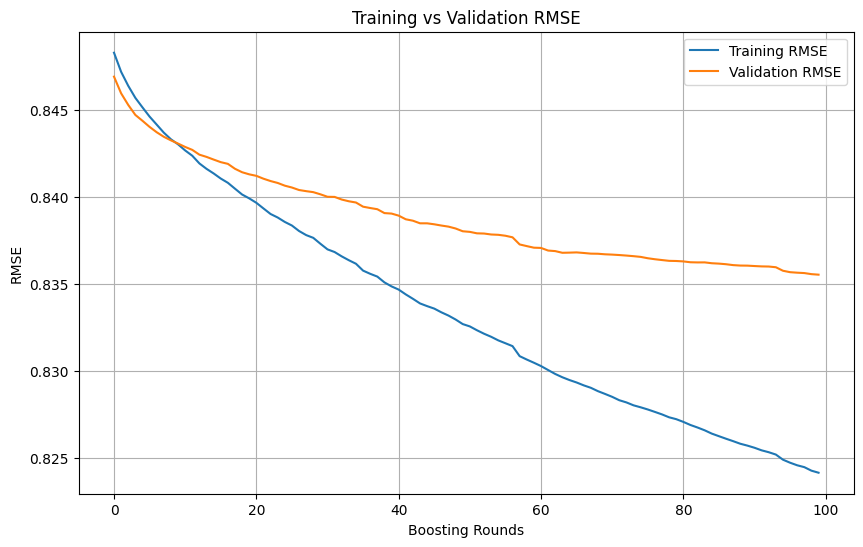

[0]	validation_0-rmse:0.84839	validation_1-rmse:0.84680
[10]	validation_0-rmse:0.84269	validation_1-rmse:0.84283
[20]	validation_0-rmse:0.83924	validation_1-rmse:0.84099
[30]	validation_0-rmse:0.83691	validation_1-rmse:0.84021
[40]	validation_0-rmse:0.83446	validation_1-rmse:0.83915
[50]	validation_0-rmse:0.83219	validation_1-rmse:0.83813
[60]	validation_0-rmse:0.83041	validation_1-rmse:0.83769
[70]	validation_0-rmse:0.82857	validation_1-rmse:0.83708
[80]	validation_0-rmse:0.82693	validation_1-rmse:0.83657
[90]	validation_0-rmse:0.82536	validation_1-rmse:0.83610
[99]	validation_0-rmse:0.82361	validation_1-rmse:0.83543


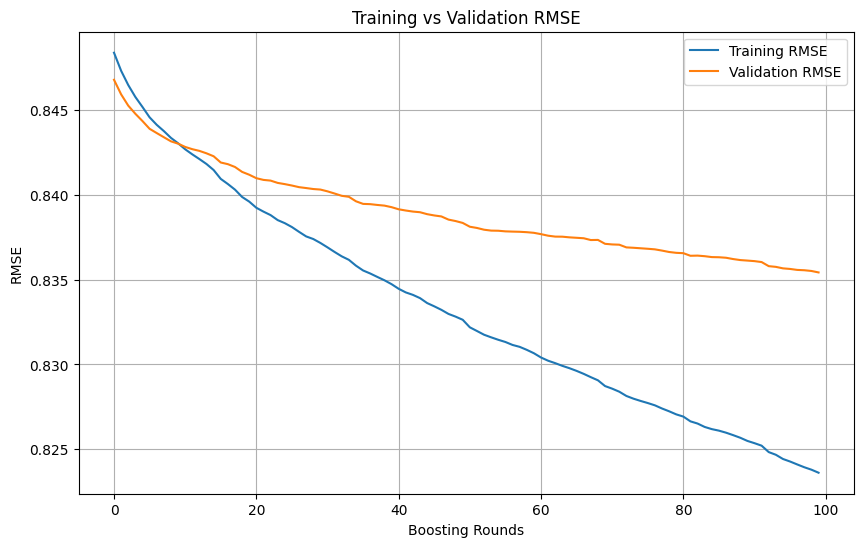

[0]	validation_0-rmse:0.84803	validation_1-rmse:0.84815
[10]	validation_0-rmse:0.84227	validation_1-rmse:0.84418
[20]	validation_0-rmse:0.83909	validation_1-rmse:0.84272
[30]	validation_0-rmse:0.83648	validation_1-rmse:0.84181
[40]	validation_0-rmse:0.83437	validation_1-rmse:0.84099
[50]	validation_0-rmse:0.83227	validation_1-rmse:0.84022
[60]	validation_0-rmse:0.83016	validation_1-rmse:0.83932
[70]	validation_0-rmse:0.82829	validation_1-rmse:0.83856
[80]	validation_0-rmse:0.82658	validation_1-rmse:0.83802
[90]	validation_0-rmse:0.82475	validation_1-rmse:0.83721
[99]	validation_0-rmse:0.82356	validation_1-rmse:0.83701


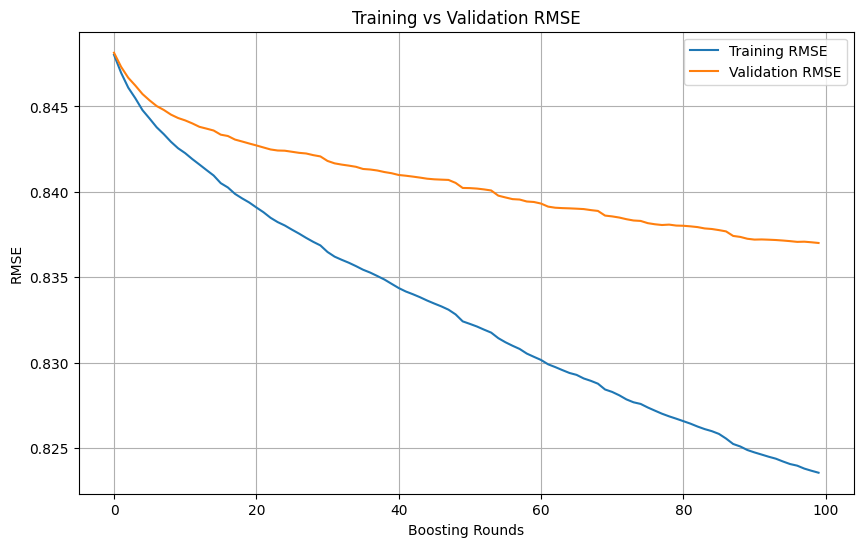

[0]	validation_0-rmse:0.84780	validation_1-rmse:0.84906
[10]	validation_0-rmse:0.84201	validation_1-rmse:0.84508
[20]	validation_0-rmse:0.83906	validation_1-rmse:0.84360
[30]	validation_0-rmse:0.83645	validation_1-rmse:0.84235
[40]	validation_0-rmse:0.83399	validation_1-rmse:0.84138
[50]	validation_0-rmse:0.83208	validation_1-rmse:0.84081
[60]	validation_0-rmse:0.83015	validation_1-rmse:0.84021
[70]	validation_0-rmse:0.82820	validation_1-rmse:0.83942
[80]	validation_0-rmse:0.82649	validation_1-rmse:0.83895
[90]	validation_0-rmse:0.82500	validation_1-rmse:0.83859
[99]	validation_0-rmse:0.82348	validation_1-rmse:0.83804


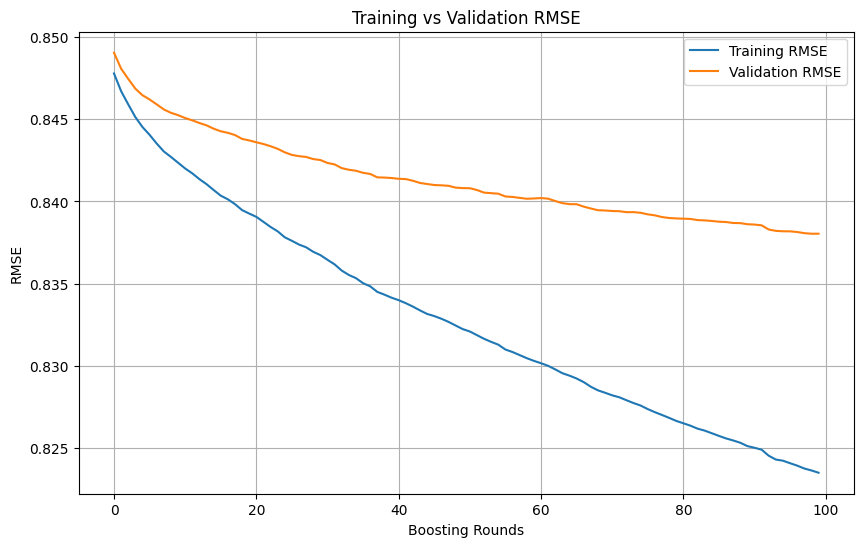

[0]	validation_0-rmse:0.84749	validation_1-rmse:0.85017
[10]	validation_0-rmse:0.84166	validation_1-rmse:0.84609
[20]	validation_0-rmse:0.83887	validation_1-rmse:0.84475
[30]	validation_0-rmse:0.83643	validation_1-rmse:0.84344
[40]	validation_0-rmse:0.83433	validation_1-rmse:0.84276
[50]	validation_0-rmse:0.83220	validation_1-rmse:0.84186
[60]	validation_0-rmse:0.83043	validation_1-rmse:0.84144
[70]	validation_0-rmse:0.82840	validation_1-rmse:0.84053
[80]	validation_0-rmse:0.82669	validation_1-rmse:0.84007
[90]	validation_0-rmse:0.82502	validation_1-rmse:0.83940
[99]	validation_0-rmse:0.82348	validation_1-rmse:0.83893


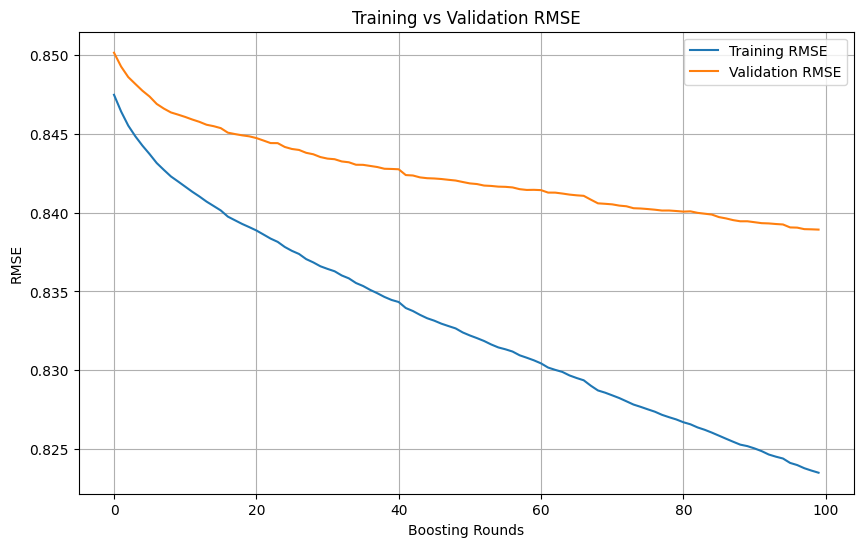

R2 score is: 0.02934297056903923


In [61]:
xgb_train(sample_train_df)